# Assignment 5: Understanding Numerosity in Vision Models

**Please do not consult external resources for this assignment.**

Make sure you have done the required reading for this homework (which was also required reading for class):

- [Testolin, A., Zou, W. Y., & McClelland, J. L. (2020). Numerosity discrimination in deep neural networks: Initial competence, developmental refinement and experience statistics. Developmental Science, 23, e12940.](https://gatech.instructure.com/courses/352188/files?preview=44758895)


## Summary

The goal of this homework is to gain comfort in working with computer vision models and to apply ML models to understand mathematical concepts. 

In more detail, you will replicate one of the computational experiments conducted by Upadhyay and Varma that was discussed in the lecture on Mathematical Cognition. That experiment investigated whether Convolutional Neural Network (CNN) models, in learning to classify images, also learn “for free” something about numbers. Numbers can be named in various ways, most commonly using digits (e.g., “3”). In this experiment, you will work with ‘numerosities’, or sets of objects (e.g., “o o o”) that can be interpreted as naming the the numbers that are their cardinalities (e.g., 3). 



![](static/numerosity.png)

Several important effects have been shown when people compare two numerosities and judge which one is greater. Together, they suggest that people understand numbers using ‘magnitude representations’ that are organized as a a Mental Number Line (MNL). This homework will focus on two such effects, the distance effect and the ratio effect. 

* **Distance effect**: The time for people to compare which of two numbers x and y is greater decreases as the distance |x − y| between them increases (Moyer & Landauer, 1967). This is consistent with the following process model: fixate x and y on the MNL and discriminate which one is ’to the right’.

* **Ratio effect**: The time to compare which of two numbers x and y is greater decreases as the ratio of the greater number over the smaller number (i.e., max (x, y) / min(x, y)) increases according to a nonlinear psychophysical function (Halberda et al., 2008).

In this homework, you will work with the CNN model VGG19 from the PyTorch model zoo. You will present images of the numerosities 1-9 to the model and read out their vector representations on the final fully connected layer. For each pair of images of differing numerosities n1 and n2, you will compute the cosine similarities of their vector representations, and store these in a matrix. You will then evaluate whether these values show evidence of the distance effect and the size effect.


## Submission guidelines

Please upload your Jupyter notebook to the Canvas Assignment. Please do not include any system specific configuration, such as the installation of dependencies, as code in the notebook (you can comment it out).

Submit your written assignments in a docx/md/txt file on Canvas.

## Dataset

You can find the necessary dataset of images in the `files/numerosity-dataset` folder.

## Install Dependencies

In [30]:
!pip install torch
!pip install Pillow
!pip install seaborn

## Load pretrained VGG19 Model

VGG19 is a deep convolution neural network developed at the University of Oxford by the Visual Geometry Group (VGG).   

There are various pretrained models available for VGG19 which are trained on different set of images. VGG19 pretrained models are mostly used after fine-tuning over some downstream vision tasks using transfer learning. However, in this assignment we will not be retraining or fine-tuning the model, we will just be analyzing the output from the final activation layer from the model.

In the below cell, we will be loading the pretrained VGG19 model provided by pytorch. We have provided the code for it. Refer here for more details about the pretrained VGG19 model: [[Pytorch Pretrained VGG19]](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg19.html)

In [31]:
import torch

def load_model(model_name):
    if model_name=="vgg19":
        model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)
    return model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = load_model("vgg19").to(device)
model.eval()

Using cache found in /Users/pennywise97/.cache/torch/hub/pytorch_vision_v0.10.0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Loading the numerosity stimuli


The function defined by us in the below cell will load all the images for a particular numerosity N (1-9).

If you notice, after loading images we perform some pre-processing over the input images. We are first resizing the images to 256x256 (images in the dataset are 1000x1000), and then normalizing it using the mean and standard deviation of the images over which the VGG19 was pretrained. This preprocessing is required for the input images in the VGG19.


In [32]:
import torchvision.transforms as transforms
from PIL import Image
import glob
import os
import numpy as np

def load_data_from_folder(N):
    transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )])

    images = []
    labels = []
    for f in glob.iglob(f'files/numerosity-dataset/'+str(N)+'/*'):
        labels.append(os.path.basename(f))
        img = Image.open(f).convert('RGB')
        images.append(np.asarray(transform(img)))

    images = np.array(images)
    images = torch.Tensor(images).to(device)
    return images

## Getting the activation from the final layer

The below function provided would give the activation output from the final layer.

We are adding a hook at the final layer to store the output. When a hook is added to a layer it will store the output of that layer for the latest forward pass.

In [33]:
def get_activation_classifier(images):
    activation = {}

    def getActivation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    h = model.classifier[6].register_forward_hook(getActivation('linearlayer'))
    out = model(images)
    h.remove()
    return torch.mean(activation['linearlayer'], 0).cpu().numpy()

## Calculate the VGG19 activation for numerosity 1-9

In this section you will calculate the VGG19 activation for numerosities 1-9 from the images provided in the dataset. Getting activation for all the numbers would take around 5-10 mins.

The activation vector of each numerosity should be added to the final activations list.

Hint: Use the load_data_from_folder() and get_activation_classifier() function defined by us

In [34]:
activations  = []
# TODO
for N in range(1, 10):
    images = load_data_from_folder(N)
    activation = get_activation_classifier(images)
    activations.append(activation)

# Convert activations to a numpy array
activations = np.array(activations)

## Printing average activation vector for each numerosity

In [35]:
for i in range(len(activations)):
    print("Activation " + str(i) + " = ", activations[i][:5])

Activation 0 =  [-1.6787999 -0.7309101 -1.0607519 -1.6177759 -1.4757572]
Activation 1 =  [-1.7288202 -0.4992202 -0.6158424 -1.683841  -0.1032971]
Activation 2 =  [-2.3511608  -0.90621775 -0.10076372 -1.9516823  -0.10535242]
Activation 3 =  [-2.6654234  -1.2415798   0.591465   -1.7915198   0.18057533]
Activation 4 =  [-2.925557   -1.3821436   0.85594606 -1.9641025   0.16604571]
Activation 5 =  [-3.1469452  -1.5756413   1.0536163  -1.9073956   0.23084684]
Activation 6 =  [-3.4792876  -1.698045    1.3360622  -1.9539013   0.43213668]
Activation 7 =  [-3.739076  -1.8062369  1.4481745 -2.0301774  0.619187 ]
Activation 8 =  [-3.8988976  -1.7887913   1.4558768  -2.0705416   0.58432734]


You can check your values for activations for different numerosities.

**Test:**

```
Activation 0 =  [-1.6787993 -0.7309083 -1.0607508 -1.617775  -1.475757 ]
Activation 1 =  [-1.7288227  -0.49922356 -0.61584264 -1.6838402  -0.10329714]
...
Activation 8 =  [-3.898906   -1.7887938   1.4558738  -2.0705464   0.58432406]
```

**Note: Here, activation 0 is the activation output for numerosity 1, activation 1 is for 2, and so on.**

### Calculate cosine similarity between numerosity

In this section you will create a 9x9 matrix showing the cosine similarity between activations of each numerosity

You may use the [`sklearn.metrics.pairwise.cosine_similarity`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) function for creating 9x9 cosine similarity table

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

# TODO: Calculate the cosine similarity between each numerosity
cosine_similarity_matrix = cosine_similarity(activations)

## Visualizing the cosine similarity matrix

[Text(0.5, 23.52222222222222, 'Number'),
 Text(50.722222222222214, 0.5, 'Number')]

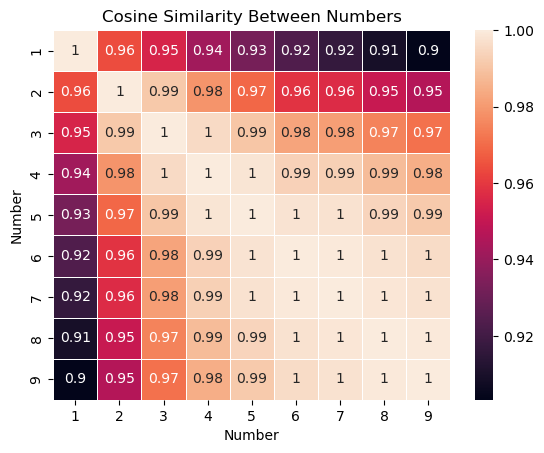

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

xticklabels = yticklabels = range(1,10)
fig, ax = plt.subplots()
sns.heatmap(cosine_similarity_matrix, annot=True, linewidth=.5, yticklabels=yticklabels, xticklabels=xticklabels, ax=ax)
ax.set_title("Cosine Similarity Between Numbers")
ax.set(xlabel="Number", ylabel="Number")

## Part 1: Distance Effect

For the distance effect, you will plot the average cosine similarity (y) at each distance |n1 − n2| (x) and compute the correlation between these two variables. A distance effect will be signaled by a negative correlation close to r = −1.


## Calculating the X and Y values for the graph of the distance effect

In this section, **you will create a list for the X and Y values of the graph depicting the distance effect and calculate the correlation between them.** X is all possible distances between the numbers |n1 − n2| and Y is the average cosine similarity at that difference. For example, at difference X = 7, Y  would be avg(cosine(1, 8), cosine(2, 9)).  

Calculate pearson correlation between distance vector (X) and average cosine similarity vector Y using [`scipy.stats.pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)

In [49]:
#TODO calculate X and Y and pearsonr correlation between them
from scipy.stats import pearsonr

distance_values = []
average_cosine_similarities = []

# i -> n1 and j -> n2 based the text provided in notebook
for i in range(1, 10):
    for j in range(1, 10):
        if i != j:
            distance = abs(i - j)
            similarity = cosine_similarity_matrix[i - 1, j - 1]

            if distance not in distance_values:
                distance_values.append(distance)
                average_cosine_similarities.append([similarity])
            else:
                index = distance_values.index(distance)
                average_cosine_similarities[index].append(similarity)

average_cosine_similarities = [np.mean(similarity) for similarity in average_cosine_similarities]
correlation_distance = pearsonr(distance_values, average_cosine_similarities)[0]

X, Y = distance_values, average_cosine_similarities

### Plot the distance effect curve

In this section, **you will plot the average cosine similarity (y) at each distance |n1 − n2| (x).**

The cosine similarity matrix calculated in the previous section will help you quickly plot the distance effect curve.

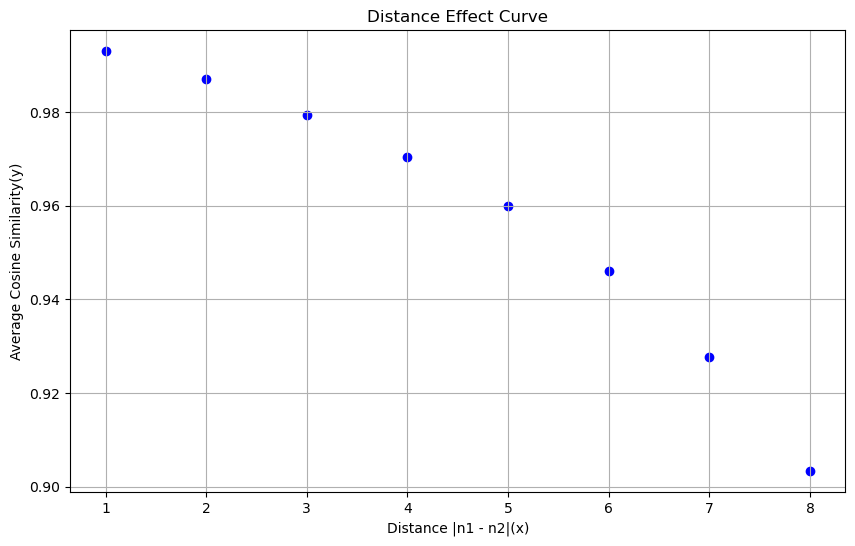

In [50]:
plt.figure(figsize=(10, 6))
plt.scatter(distance_values, average_cosine_similarities, color='blue', marker='o')
plt.title("Distance Effect Curve")
plt.xlabel("Distance |n1 - n2|(x)")
plt.ylabel("Average Cosine Similarity(y)")
plt.xticks(distance_values)
plt.grid()
plt.show()

## Below is the expected distance effect plot 

![](static/expected_distance_effect.png)

## Fit a linear function over the above plotted curve and get the slope of the line

In this section, we have provided code for fitting a linear function over the distance effect points.

Fitted parameters:
Slope -0.012330791779926844
Intercept 1.013850903936795


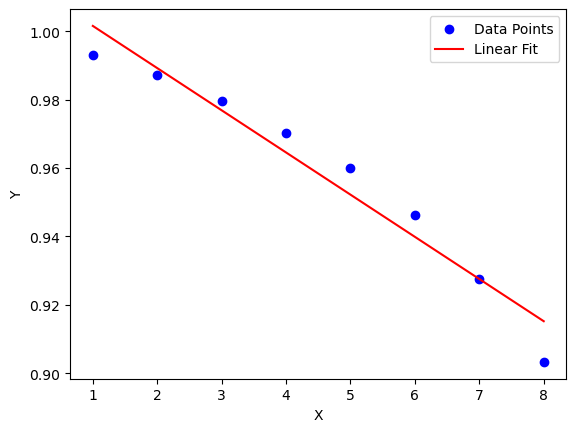

In [52]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Fit the linear function using curve_fit
params = linregress(X, Y)

# Extract the fitted parameters
slope, intercept = params.slope, params.intercept

# Calculate the predicted values from the fitted function
y_pred = slope * np.array(X) + intercept

fig, ax = plt.subplots()

# Plot the data points
ax.scatter(X, Y, label='Data Points', color='blue')

# Plot the linear fit
ax.plot(X, y_pred, label='Linear Fit', color='red')


# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()


# Print the fitted parameters
print("Fitted parameters:")
print('Slope', slope)
print('Intercept', intercept)


## Part 2 - Ratio Effect

You will repeat the same process for the ratio effect, with the x-axis as the ratio $\frac{max(n1, n2)}{min(n1, n2)}$ of the comparisons between each numerosity ($n1 \neq n2$). Here, you will fit a negative exponential function to model the results; a ratio effect will be signaled by an R^2 value close to 1. The linking hypothesis is that the more similar the representations of two numbers, the slower they are compared.


### Calculating the X and Y values for the graph of the ratio effect

In this section, **you will create a list of X and Y values for the graph of the ratio effect and calculate the correlation between them.** X is all possible ratios of the form $\frac{max(n1, n2)}{min(n1, n2)}$ and Y is the cosine similarity at that ratio.   


In [53]:
#TODO calculate X and Y and pearsonr correlation between them
ratio_values = []
cosine_similarities_at_ratios = []
average_cosine_similarities_ratios = []

# i = n1 and j = n2
for i in range(1, 10):
    for j in range(1, 10):
        if i != j:
            ratio_values.append( max(i, j) / min(i, j))
            cosine_similarities_at_ratios.append(cosine_similarity_matrix[i - 1, j - 1])

unique_ratios = sorted(set(ratio_values))

for ratio in unique_ratios:
    similarities = [cosine_similarities_at_ratios[i] for i in range(len(ratio_values)) if ratio_values[i] == ratio]
    average_cosine_similarities_ratios.append(np.mean(similarities))

correlation_ratio = pearsonr(unique_ratios, average_cosine_similarities_ratios)[0]

X, Y = unique_ratios, average_cosine_similarities_ratios

### Plotting the ratio effect

In this section, **you will plot the average cosine similarity (y) for each possible ratio $\frac{max(n1, n2)}{min(n1, n2)}$ (x).**

The cosine similarity matrix calculated in the previous section will again help you quickly plot the ratio effect curve.

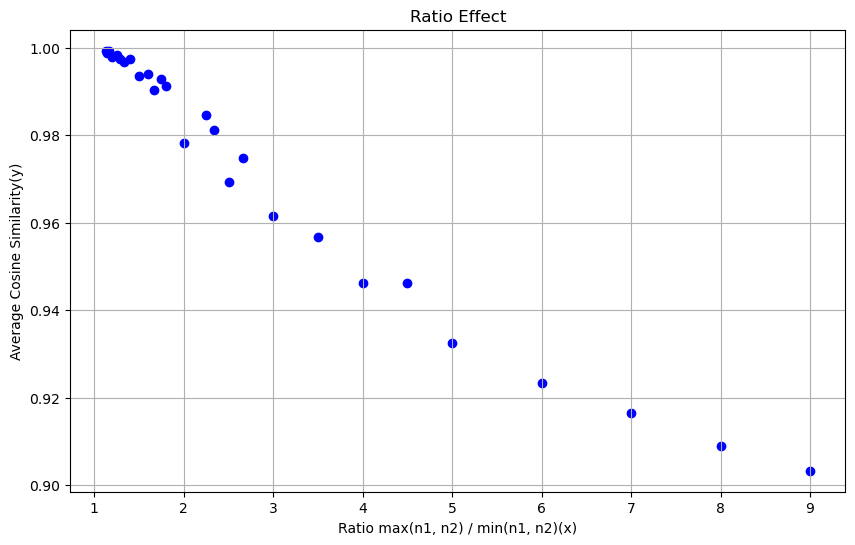

In [54]:
#TODO: Write the code for plotting the ratio effect curve
plt.figure(figsize=(10, 6))
plt.scatter(unique_ratios, average_cosine_similarities_ratios, color='blue', marker='o')
plt.title("Ratio Effect")
plt.xlabel("Ratio max(n1, n2) / min(n1, n2)(x)")
plt.ylabel("Average Cosine Similarity(y)")
plt.grid()
plt.show()

### Below is the expected ratio effect plot 

![](static/expected_ratio_effect.png)



### Fit a negative exponential curve over the above ratio effect points

In this section, we have provided code for fitting an exponential curve over the ratio effect points plotted in the above section.

We have plotted the scatter points, fitted curve and reported the R^2 value for the fitted curve. R-squared value for a fitted curve can be calculated using the below given formula.

$$R^2 = 1 - \frac{\sum_{i=1}^N (y_i - \hat{y}_i)^2}{\sum_{i=1}^N (y_i - \bar{y})^2}$$

where $\bar{y}$ is the mean of the y and $\hat{y}_i$ is the predicted y.

R-squared value = 0.9900917970135978


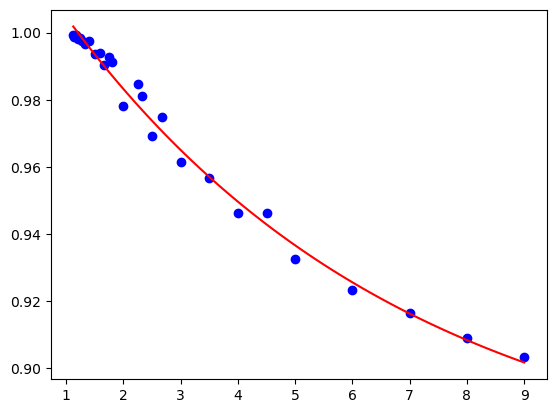

In [55]:
import numpy as np
from scipy.optimize import curve_fit

# Fit the curve
params, covariance = curve_fit(lambda t, a, b, c: a * np.exp(-b * t) + c, X, Y,maxfev=1000000)

# Extract the fitted parameters
a_fit, b_fit, c_fit = params

# Calculate the predicted values from the fitted curve
y_pred = a_fit * np.exp(np.array(X)* - b_fit) + c_fit

# Calculate the mean of the actual data points
y_mean = np.mean(Y)

# Calculate R^2
ss_res = np.sum((Y - y_pred)**2)
ss_tot = np.sum((Y - y_mean)**2)
r_squared = 1 - (ss_res / ss_tot)

print("R-squared value =", r_squared)

# Plot the data points

fig, ax = plt.subplots()
plt.scatter(X, Y, label='Data Points', color='blue')

# Plot the fitted curve
x_fit = np.linspace(min(X), max(X), 100)  # Generate points for the fitted curve
y_fit = a_fit * np.exp(np.array(x_fit)* - b_fit) + c_fit
plt.plot(x_fit, y_fit, label='Fitted Curve', color='red')


## Questions

Respond to each question in one or two paragraphs. Remember, we are looking for connections to psychological plausibility in humans.

(1) You computed the fit of the model to the distance effect and to the size effect. How would you interpret the r (correlation) and R^2 values that you obtained?  

(2) You have modeled numerosity processing using CNN models. Imagine extending this to model the development of numerosity. You would find checkpointed CNN models and use the stimuli to document how their numerosity representations change over training. Do you think the model would mimic the developmental progression shown by children? 

![](static/children_distance_effect.png)

(3) You have examined the activations at the final fully connected layer. Would you expect to see the same results at other layers, and why? 

(4) Why do you think that Vision models trained on image classification are sensitive to numerical information? 

(5) This exercise shows the alignment between humans and CNNs for numerosity understanding. The importance of this is clear to cognitive science. What is the value, if any, of these findings for computer vision research? 

# Answers
1. Yes, i computed the model fit to distance effect and to the ratio effect. The correlation values mean how closely related a data point is to another data point. For example, the values for same number was always 1, 100%, because their cosine similarity is the same and calculating distance between those vector is a value 0 which means they are the same value. Like the case for 1 and 1 or 7 and 7, the correlation of these values is 1. However, we do see some other values like 5 and 7 that also have the cosine similarity that is something that is up for discussion. In the linear fit plot, we can see the linear fit line vs the data points we just plotted and we can see they are following a similar trajectory but linear fit curve is obviously a straight line and the data points I came up with have a slight parabolic structure. For the distance and ratio effects, a higher r (correlation) value would indicate that the model's predictions align well with the observed data, suggesting psychological plausibility.
For the r^2 values, it is almost contrary to the previous discussion, it states that the more similar the two numbers being compared are, the more time it takes to compare them. The R^2 value was very close to 1 as anticipated - R-squared value = 0.9900917970135978. In the curve plotted above, we plotted the cosine similarity of a ratio max(n1, n2) / min(n1, n2) to avg similarities rather than just distance between them to avg similarities. We can see that the linear fit line is much closely emulating the ratio vs avg similarity line. A high R^2 suggests that the model is capturing a significant part of the effects' variability, meaning the model closely mimics how humans perceive distance and size differences. It is an extremely interesting concept.
2. Yes, i think the check-pointed CNN models would mimic the development progression shown by children. A toddler can be compared to a newly trained CNN model which might make mistakes and might give delayed answers, so we could see that blue line with a lot of deviations. An adult can be compared to a heavily trained high accuracy CNN model which might give all the answers within less than 0.5s and most of them accurate. It is a very interesting hypothesis but to think about how humans are mature at 25, CNN models can mature within a few days. So in spite of showing the same graphs and same trends, the lifespan might be much shorter for a model as compared to humans.
3. The answers at the final fully connected layers are what we see as results but if we have to talk about what do we see in the intermediate layers we would have to understand how and what the layers are and do. At a high level, I'd think the process in the intermediate layer focuses on various characteristics like edge detection, or lines, textures, and as it comes to the final layer the number is processed correctly. For example, if we talk about the number 7, the intermediate layers might have partially incorrectly narrowed it down to either 1 or 7, and as we approach the final layer, the model reaches a conclusion that due to a number of factors taken into account, this is in fact 7 and not 1. Or another example could be number 8, which looks like 2 number "3"'s stacked against each other. Some of the intermediate layers might only process the right half of the image and consider it as 3 but later as it goes on, it might consider the top loop and consider it the number 9 instead of 8, towards the final layer is where we really drill down and conclude that it is actually an 8 all along. In conclusion, the same patterns seen at the final layer may not be as clear earlier because earlier layers prioritize lower-level image characteristics, not abstract numerical processing.
4. It is because of visual representation of numbers, like the number 1 has typical characteristics that number 5 clearly doesn't, talking about totally different looking numbers. Numbers 1 and 7 have different characteristics but can often be misinterpreted because of certain similar characteristics like the straight line and one line extending from the top left. And i think that most classifications have to deal with numbers every now and then like there are 5 different sets of images and for the vision model to correctly classify these images into 5 different clusters, this involves some sort of quantitative distinctions and that leads to my point that there is some overlap between the normal classification a model does with it classifying numerical information with a greater sensitivity. Plus the work on images have begun recently, the work on number parsing and OCR technologies has been in works since decades that might also contribute to the advancement in numerical sensitivity. The dataset on the other hand might have played a role too, comparing the number "1" to lets say a "beak" of a bird, the number 1 hasn't changed since the advent of time for the sake of simplicity vs due to evolution, the beak has evolved too and we have discovered more species of birds so we have more variety of birds and beaks, and the dataset is not the same as it used to.
5. The exercise shows that there is a close relation between how humans classify numbers and how a vision model does too. It is indeed a big leap for cognitive science, computer vision research, and artificial intelligence because in a way we are getting closer to understanding how a human brain works and how to emulate it. If a vision model is able to correctly classify numbers, it will also means that we will need less numbers of other models that specialize in this task, for example, instead of having OCR technology and a separate complicated neural network correctly identifying only numbers, we can just have one vision model to train and correctly classify numbers. In the bigger scheme of things, it will help reduce the Carbon footprints machine learning or Artificial Intelligence models have due to the extensive power usage during the training phase.